In [1]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Trabajo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import shutil
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alejandroczernikier/properati-argentina-dataset")

print("Path to dataset files:", path)

dest = "../data/"
os.makedirs(dest, exist_ok=True)
for file in os.listdir(path):
    shutil.move(os.path.join(path, file), os.path.join(dest, file))

100%|██████████| 227M/227M [00:09<00:00, 26.3MB/s] 

Extracting files...


Path to dataset files: C:\Users\Trabajo\.cache\kagglehub\datasets\alejandroczernikier\properati-argentina-dataset\versions\1


In [1]:
import pandas as pd
df = pd.read_csv("../data/entrenamiento.csv")

In [4]:
print(df.columns)

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'price'],
      dtype='object')


creo un base de datos properati con dbeaver

In [5]:
import pandas as pd
import sqlite3
import os

csv_path = "../data/entrenamiento.csv"
folder_path = os.path.join("..", "data")
db_path = os.path.join(folder_path, "Properati.db")
table_name = "entranamiento"

def crear_base_datos():
    """Crea la base de datos SQLite y la pobla con los datos del torneo"""
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Crear tabla de jugadores
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS entrenamiento (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        ad_type TEXT,
        start_date DATE,
        end_date DATE,
        created_on DATE,
        lat FLOAT,
        lon FLOAT,
        l1 TEXT,  
        l2 TEXT,
        l3 TEXT,
        l4 TEXT, 
        l5 TEXT,    
        l6 TEXT,
        rooms INTEGER,
        bedrooms INTEGER,
        bathrooms INTEGER,  
        surface_total FLOAT,
        surface_covered FLOAT,
        currency TEXT,
        price_period TEXT,
        title TEXT,
        description TEXT,
        property_type TEXT,
        operation_type TEXT,
        price FLOAT
    )
    ''')
    
    # Leer datos del CSV
    df = pd.read_csv(csv_path)
    
    # Convertir el DataFrame a una lista de tuplas para la inserción
    datos_propiedades = df[['ad_type', 'start_date', 'end_date', 'created_on', 
                           'lat', 'lon', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6',
                           'rooms', 'bedrooms', 'bathrooms', 'surface_total', 
                           'surface_covered', 'currency', 'price_period',
                           'title', 'description', 'property_type', 
                           'operation_type', 'price']].values.tolist()
    
    # Insertar datos
    cursor.executemany('''
    INSERT INTO entrenamiento (
        ad_type, start_date, end_date, created_on, lat, lon,
        l1, l2, l3, l4, l5, l6,
        rooms, bedrooms, bathrooms,
        surface_total, surface_covered,
        currency, price_period,
        title, description,
        property_type, operation_type, price
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', datos_propiedades)
    
    conn.commit()
    conn.close()
    print("Base de datos creada y datos insertados exitosamente!")

if not(os.path.exists(db_path)):
    crear_base_datos()

Base de datos creada y datos insertados exitosamente!


# Preprocesamiento con Pipelines

Los pipelines de scikit-learn nos permiten encadenar varios pasos de preprocesamiento y modelado de manera ordenada. Esto nos ayuda a:
1. Mantener el código organizado
2. Evitar data leakage
3. Aplicar las mismas transformaciones a datos de entrenamiento y test
4. Facilitar la experimentación con diferentes combinaciones de preprocesamiento

In [9]:
# Importar las bibliotecas necesarias
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

# Cargar los datos
#df = pd.read_csv("../data/entrenamiento.csv")

# Ruta a la base de datos
db_path = "../data/Properati.db"

# Conexión y consulta
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM entrenamiento", conn)
conn.close()

# Definir las columnas numéricas y categóricas
numeric_features = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_features = ['property_type', 'operation_type', 'currency']

# Crear los pipelines para cada tipo de dato
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Rellenar valores faltantes con la mediana
    ('scaler', StandardScaler())  # Estandarizar los datos numéricos
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Rellenar valores faltantes con 'missing'
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # Codificación one-hot dropping una categoría
])

# Combinar los transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear el pipeline completo
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Ajustar el pipeline a los datos
X = df[numeric_features + categorical_features]
pipeline.fit(X)

# Transformar los datos
X_transformed = pipeline.transform(X)

# Mostrar las dimensiones de los datos transformados
print("Forma de los datos transformados:", X_transformed.shape)

# Obtener los nombres de las características después de la transformación
feature_names = (numeric_features + 
                [f"{feature}_{val}" for feature, vals in 
                 zip(categorical_features, 
                     pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot'].categories_) 
                 for val in vals[1:]])

# Mostrar las primeras características transformadas
transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
print("\nPrimeras 5 filas de los datos transformados:")
print(transformed_df.head())

Forma de los datos transformados: (992192, 20)

Primeras 5 filas de los datos transformados:
      rooms  bedrooms  bathrooms  surface_total  surface_covered  \
0  0.059748 -0.019964   0.461032      -0.065134        -0.004511   
1  0.059748 -0.019964   0.461032      -0.071648        -0.004674   
2 -0.773542 -0.019964  -0.548966      -0.077799        -0.004919   
3 -0.773542 -0.608837  -0.548966      -0.072733        -0.005083   
4  0.059748 -0.019964  -0.548966      -0.075628        -0.004736   

   property_type_Casa de campo  property_type_Cochera  \
0                          0.0                    0.0   
1                          0.0                    0.0   
2                          0.0                    0.0   
3                          0.0                    0.0   
4                          0.0                    0.0   

   property_type_Departamento  property_type_Depósito  \
0                         1.0                     0.0   
1                         1.0            

Creo la tabla entrenamiento_procesado

In [10]:
import sqlite3

# Obtener los nombres de las columnas del DataFrame preprocesado
columnas = transformed_df.columns

# Generar el SQL para crear la tabla
campos_sql = ',\n    '.join([f'"{col}" REAL' for col in columnas])  # Usamos REAL para datos numéricos, puedes ajustar si tienes columnas categóricas codificadas como texto

sql_create = f'''
CREATE TABLE IF NOT EXISTS entrenamiento_preprocesado (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    {campos_sql}
)
'''

# Crear la tabla en la base de datos
conn = sqlite3.connect(db_path)
conn.execute(sql_create)
conn.commit()
conn.close()
print("Tabla entrenamiento_preprocesado creada correctamente.")

Tabla entrenamiento_preprocesado creada correctamente.


usando la nueva clase propiedad_procesada, guardo los datos en la nueva tabla de la base de datos

In [15]:
import sys
sys.path.append('../')  # Ajustamos el path para incluir la carpeta raíz del proyecto
from clases.propiedad_procesada import PropiedadPreprocesada
import sqlite3

# Conexión a la base de datos
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

try:
    # Recorrer cada fila del DataFrame preprocesado y guardar en la tabla
    for _, row in transformed_df.iterrows():
        prop = PropiedadPreprocesada(**row.to_dict())
        prop.insertar_en_db(conn, tabla="entrenamiento_preprocesado")
    
    conn.commit()
    print("Datos insertados correctamente en entrenamiento_preprocesado.")
except Exception as e:
    print(f"Error al insertar datos: {str(e)}")
finally:
    conn.close()

Datos insertados correctamente en entrenamiento_preprocesado.


## Explicación del Pipeline

El pipeline anterior realiza varios pasos de preprocesamiento:

1. Para variables numéricas (`rooms`, `bedrooms`, etc.):
   - Rellena valores faltantes con la mediana
   - Estandariza los datos (media 0, desviación estándar 1)

2. Para variables categóricas (`property_type`, `operation_type`, `currency`):
   - Rellena valores faltantes con 'missing'
   - Aplica codificación one-hot eliminando una categoría para evitar multicolinealidad

Ventajas de usar este pipeline:
- Todo el preprocesamiento se encapsula en un solo objeto
- Se puede aplicar fácilmente a nuevos datos
- Evita data leakage al aplicar las transformaciones correctamente
- Se puede combinar con modelos de ML en un pipeline más grande

# Modelo de Predicción de Precios

Ahora vamos a crear un modelo de regresión para predecir precios de propiedades. El proceso se divide en:
1. Preparación de datos
2. Entrenamiento del modelo
3. Evaluación de resultados

In [40]:
# Importar bibliotecas necesarias
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Preparar los datos - Filtrar solo propiedades en USD para consistencia
df_usd = df[df['currency'] == 'USD'].copy()

# Verificar que tenemos suficientes datos
print(f"Número de propiedades en USD: {len(df_usd)}")
print(f"Porcentaje del total: {(len(df_usd) / len(df) * 100):.2f}%")

Número de propiedades en USD: 722707
Porcentaje del total: 72.84%


## Preparación de Features y Target

Preparamos los datos para el entrenamiento:
1. Seleccionamos las características (features)
2. Transformamos el precio con logaritmo (para manejar la distribución sesgada)
3. Dividimos en conjuntos de entrenamiento y prueba

In [41]:
# Preparar features y target
X = df_usd[numeric_features + categorical_features]
y = df_usd['price']

# Aplicar transformación logarítmica al precio
y = np.log1p(y)

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensiones de los datos:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Dimensiones de los datos:
X_train: (578165, 8)
X_test: (144542, 8)
y_train: (578165,)
y_test: (144542,)


## Entrenamiento del Modelo

Creamos y entrenamos el pipeline completo que incluye:
1. Preprocesamiento de datos
2. Modelo de regresión lineal

In [42]:
# Crear un pipeline completo con preprocesamiento y modelo
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

try:
    # Ajustar el pipeline completo
    full_pipeline.fit(X_train, y_train)
    print("Modelo entrenado exitosamente!")
    
except Exception as e:
    print(f"Error durante el entrenamiento: {str(e)}")

Modelo entrenado exitosamente!


## Evaluación del Modelo

Evaluamos el rendimiento del modelo usando:
1. Métricas en escala logarítmica (R² y RMSE)
2. Métricas en escala real de dólares
3. Ejemplos de predicciones reales vs predichas

In [44]:
try:
    # Hacer predicciones
    y_pred = full_pipeline.predict(X_test)

    # Convertir predicciones de log a valores reales
    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred)

    # Evaluar el modelo
    print("\nMétricas en escala logarítmica:")
    print("R² Score:", r2_score(y_test, y_pred))
    print("RMSE (log):", np.sqrt(mean_squared_error(y_test, y_pred)))
    
    print("\nMétricas en escala real (USD):")
    print("R² Score:", r2_score(y_test_real, y_pred_real))
    print("RMSE (USD):", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))
    
    # Mostrar algunos ejemplos de predicciones
    print("\nEjemplos de predicciones (primeros 5):")
    for real, pred in zip(y_test_real[:5], y_pred_real[:5]):
        print(f"Precio real: ${real:,.2f} | Precio predicho: ${pred:,.2f}")

except Exception as e:
    print(f"Error durante la evaluación: {str(e)}")


Métricas en escala logarítmica:
R² Score: 0.5333764170606514
RMSE (log): 0.8197211730062008

Métricas en escala real (USD):
R² Score: -89.9372105974021
RMSE (USD): 4200600.995248153

Ejemplos de predicciones (primeros 5):
Precio real: $800,000.00 | Precio predicho: $88,467.44
Precio real: $480,000.00 | Precio predicho: $126,025.97
Precio real: $16,500.00 | Precio predicho: $82,322.72
Precio real: $360,000.00 | Precio predicho: $272,624.62
Precio real: $62,000.00 | Precio predicho: $87,632.47


## Almacenamiento de Resultados en Base de Datos

Guardamos las métricas y predicciones del modelo para análisis posterior y seguimiento del rendimiento.

In [45]:
# Importar la clase ModeloPrecios
import sys
import os

# Asegurarnos de que el path está correctamente configurado
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from clases.modelos.modelo_precios import ModeloPrecios

# Crear instancia del modelo
modelo = ModeloPrecios(full_pipeline)

# Crear tablas en la base de datos
modelo.crear_tablas(db_path)

# Features utilizados
features_used = ', '.join(numeric_features + categorical_features)

# Evaluar modelo y guardar resultados
try:
    metrica = modelo.evaluar_y_guardar(X_test, y_test, features_used, db_path)

    print("\nMétricas del modelo:")
    print(f"R² Score (log): {metrica.r2_score_log:.4f}")
    print(f"RMSE (log): {metrica.rmse_log:.4f}")
    print(f"R² Score (USD): {metrica.r2_score_usd:.4f}")
    print(f"RMSE (USD): {metrica.rmse_usd:.4f}")
except Exception as e:
    print(f"Error al evaluar y guardar el modelo: {str(e)}")
    print("Path actual:", os.getcwd())
    print("Python path:", sys.path)

Resultados guardados exitosamente en la base de datos.

Métricas del modelo:
R² Score (log): 0.5334
RMSE (log): 0.8197
R² Score (USD): -89.9372
RMSE (USD): 4200600.9952


### Beneficios del Almacenamiento en Base de Datos

1. **Seguimiento del Rendimiento**:
   - Histórico de métricas para diferentes versiones del modelo
   - Comparación de rendimiento en el tiempo
   - Identificación de áreas de mejora

2. **Análisis de Predicciones**:
   - Patrones en errores de predicción
   - Identificación de casos atípicos
   - Evaluación de la consistencia del modelo

3. **Documentación**:
   - Registro de features utilizados
   - Seguimiento de cambios en el modelo
   - Auditoría de resultados

# Comparación de Algoritmos de Regresión

Comparamos el rendimiento de diferentes algoritmos de regresión para encontrar el mejor modelo para nuestro problema:

1. Linear Regression (ya implementado)
   - Ventajas: Simple, interpretable
   - Desventajas: Solo captura relaciones lineales

2. Random Forest Regressor
   - Ventajas: 
     * Captura relaciones no lineales
     * Maneja bien datos ruidosos
     * Proporciona importancia de features
   - Desventajas: Menos interpretable

In [46]:
# Importar Random Forest
from sklearn.ensemble import RandomForestRegressor

# Crear pipeline con Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Crear instancia del modelo Random Forest
modelo_rf = ModeloPrecios(rf_pipeline, model_type="RandomForest")

# Entrenar el modelo
try:
    rf_pipeline.fit(X_train, y_train)
    print("Modelo Random Forest entrenado exitosamente!")
    
    # Evaluar y guardar resultados
    metrica_rf = modelo_rf.evaluar_y_guardar(X_test, y_test, features_used, db_path)
    
    print("\nMétricas del modelo Random Forest:")
    print(f"R² Score (log): {metrica_rf.r2_score_log:.4f}")
    print(f"RMSE (log): {metrica_rf.rmse_log:.4f}")
    print(f"R² Score (USD): {metrica_rf.r2_score_usd:.4f}")
    print(f"RMSE (USD): {metrica_rf.rmse_usd:.4f}")
    
except Exception as e:
    print(f"Error durante el entrenamiento de Random Forest: {str(e)}")

Modelo Random Forest entrenado exitosamente!
Resultados guardados exitosamente en la base de datos.

Métricas del modelo Random Forest:
R² Score (log): 0.6534
RMSE (log): 0.7065
R² Score (USD): 0.2270
RMSE (USD): 387282.1653


In [47]:
# Hyperparameter tuning para Random Forest usando GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
try:
    grid.fit(X_train, y_train)
    print("GridSearchCV terminado. Mejoros parámetros:", grid.best_params_)

    # Mejor estimador (incluye preprocessor y regressor con mejores hiperparámetros)
    best_rf_pipeline = grid.best_estimator_

    # Evaluar y guardar resultados con la clase ModeloPrecios
    modelo_rf_tuned = ModeloPrecios(best_rf_pipeline, model_type="RandomForest_Tuned")
    metrica_rf_tuned = modelo_rf_tuned.evaluar_y_guardar(X_test, y_test, features_used, db_path)

    print("\nMétricas del modelo Random Forest (tuned):")
    print(f"R² Score (log): {metrica_rf_tuned.r2_score_log:.4f}")
    print(f"RMSE (log): {metrica_rf_tuned.rmse_log:.4f}")
    print(f"MAE (log): {metrica_rf_tuned.mae_log:.4f}")
    print(f"R² Score (USD): {metrica_rf_tuned.r2_score_usd:.4f}")
    print(f"RMSE (USD): {metrica_rf_tuned.rmse_usd:.4f}")
    print(f"MAE (USD): {metrica_rf_tuned.mae_usd:.4f}")

except Exception as e:
    print(f"Error durante GridSearchCV o evaluación: {str(e)}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
GridSearchCV terminado. Mejoros parámetros: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Resultados guardados exitosamente en la base de datos.

Métricas del modelo Random Forest (tuned):
R² Score (log): 0.6561
RMSE (log): 0.7037
Error durante GridSearchCV o evaluación: 'MetricaModelo' object has no attribute 'mae_log'


In [ ]:
# Hyperparameter tuning para XGBoost usando GridSearchCV
import sys
import subprocess

try:
    from xgboost import XGBRegressor
except Exception:
    print("xgboost no encontrado — instalando xgboost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"]) 
    from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
import joblib
import os

# Definir pipeline XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0))
])

param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 6],
    'regressor__subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

try:
    grid_xgb.fit(X_train, y_train)
    print("XGBoost GridSearchCV terminado. Mejores parámetros:", grid_xgb.best_params_)

    best_xgb_pipeline = grid_xgb.best_estimator_

    # Evaluar y guardar resultados con la clase ModeloPrecios
    modelo_xgb = ModeloPrecios(best_xgb_pipeline, model_type="XGBoost_Tuned")
    metrica_xgb = modelo_xgb.evaluar_y_guardar(X_test, y_test, features_used, db_path)

    # Guardar pipeline entrenado
    models_dir = os.path.join('..', 'models')
    os.makedirs(models_dir, exist_ok=True)
    joblib.dump(best_xgb_pipeline, os.path.join(models_dir, 'xgb_best_pipeline.pkl'))
    print(f"Pipeline XGBoost guardado en {os.path.join(models_dir, 'xgb_best_pipeline.pkl')}")

    # Mostrar métricas
    print("\nMétricas XGBoost:")
    print(f"R2 (log): {metrica_xgb.r2_score_log:.4f}, RMSE (log): {metrica_xgb.rmse_log:.4f}, MAE (log): {metrica_xgb.mae_log:.4f}")
    print(f"R2 (USD): {metrica_xgb.r2_score_usd:.4f}, RMSE (USD): {metrica_xgb.rmse_usd:.4f}, MAE (USD): {metrica_xgb.mae_usd:.4f}")

except Exception as e:
    print(f"Error durante GridSearchCV o evaluación XGBoost: {str(e)}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


## Comparación de Resultados

Analizamos las diferencias entre los modelos para determinar cuál se ajusta mejor a nuestros datos.

Comparación de modelos:

Métricas de los modelos:
      model_type  r2_score_log  rmse_log  r2_score_usd     rmse_usd
    RandomForest      0.653409  0.706467      0.227010 3.872822e+05
LinearRegression      0.533376  0.819721    -89.937211 4.200601e+06
LinearRegression      0.533376  0.819721    -89.937211 4.200601e+06
LinearRegression      0.533376  0.819721    -89.937211 4.200601e+06


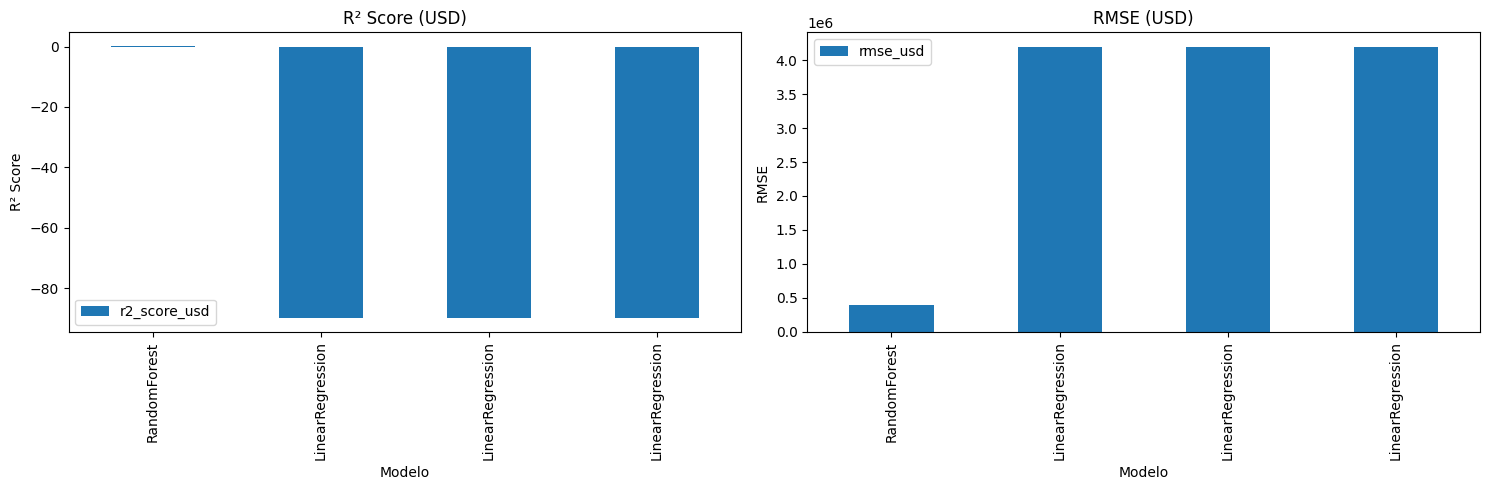

In [ ]:
# Consultar las métricas guardadas en la base de datos
conn = sqlite3.connect(db_path)
metrics_df = pd.read_sql_query('''
    SELECT 
        model_type,
        timestamp,
        r2_score_log,
        rmse_log,
        mae_log,
        r2_score_usd,
        rmse_usd,
        mae_usd
    FROM model_metrics
    ORDER BY timestamp DESC
    LIMIT 20
''', conn)
conn.close()

# Mostrar comparación
print("Comparación de modelos:")
print("\nMétricas de los modelos:")
print(metrics_df[['model_type', 'r2_score_log', 'rmse_log', 'mae_log', 'r2_score_usd', 'rmse_usd', 'mae_usd']].to_string(index=False))

# Crear visualización de comparación
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score comparación
metrics_df.plot(kind='bar', x='model_type', y='r2_score_usd', ax=axes[0], title='R² Score (USD)')
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('Modelo')

# RMSE comparación
metrics_df.plot(kind='bar', x='model_type', y='rmse_usd', ax=axes[1], title='RMSE (USD)')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Modelo')

# MAE comparación
metrics_df.plot(kind='bar', x='model_type', y='mae_usd', ax=axes[2], title='MAE (USD)')
axes[2].set_ylabel('MAE')
axes[2].set_xlabel('Modelo')

plt.tight_layout()
plt.show()